In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# set version
# version = 5
full = True

# load metrics
if full:
    metrics = pd.read_csv("lightning_logs/gpu_multi_128/metrics.csv")#.drop(columns="step")
else:
    metrics = pd.read_csv(f"lightning_logs/version_{version}/metrics.csv").drop(
        columns="step"
    )
metrics

,epoch,nc_layer_0,nc_layer_1,nc_layer_2,nc_layer_3,nc_layer_4,nc_output,step,train_loss
0,0,1632.773682,9799.035156,1423.804810,7368.819336,1860.217041,2.695589e+03,31,0.692960
1,1,7.178256,310.597046,390197.812500,16856.763672,95065.257812,4.811994e+08,63,0.692694
2,2,19.093903,211.893661,2223.517578,1358.104492,900.142700,9.359729e+02,95,0.692947
3,3,3.919065,69.830444,1523.071655,2155.765137,3305.590332,3.583870e+03,127,0.692772
4,4,2.689455,27.048313,596.205688,1031.718140,7038.376953,5.951729e+03,159,0.692769
...,...,...,...,...,...,...,...,...,...
152,152,0.759081,0.700315,0.528914,0.500906,0.504362,5.030072e-01,4895,0.427024
153,153,0.759079,0.700316,0.528914,0.500905,0.504361,5.030074e-01,4927,0.427024
154,154,0.759082,0.700316,0.528914,0.500905,0.504361,5.030071e-01,4959,0.427024
155,155,0.759083,0.700316,0.528914,0.500905,0.504361,5.030071e-01,4991,0.427024


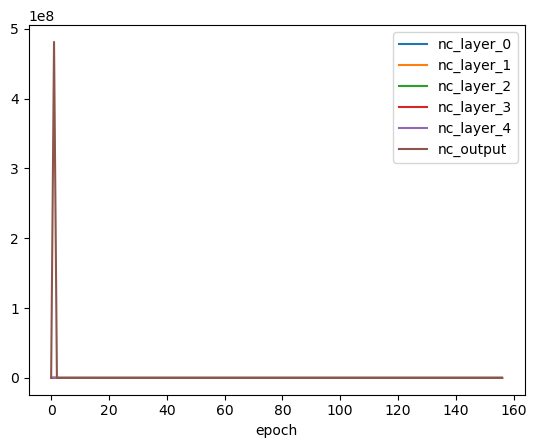

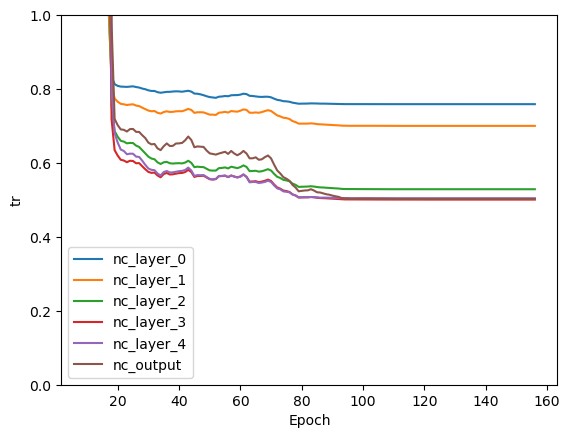

In [27]:
# plot NC1
nc_cols = metrics.columns[metrics.columns.str.contains("nc_")]
metrics.plot(x="epoch", y=nc_cols)
# plt.ylim(0,20000)
# plt.xlim(2,20)
plt.show()

# plot rolling average (window size == 10)
rolling_avg = metrics[nc_cols].rolling(10).mean()
plt.plot(metrics["epoch"], rolling_avg, label=rolling_avg.columns)
plt.legend()
plt.ylim(0,1)
# plt.xlim(9,20)
plt.xlabel("Epoch")
plt.ylabel(r"$\operatorname{tr}$")
plt.show()

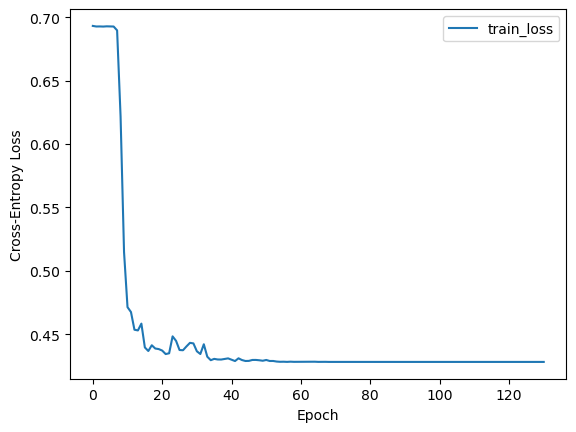

In [21]:
# plot train loss
metrics.plot(x="epoch", y=["train_loss"])
# plt.ylim(0.3,0.9)
# plt.xlim(0,200)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

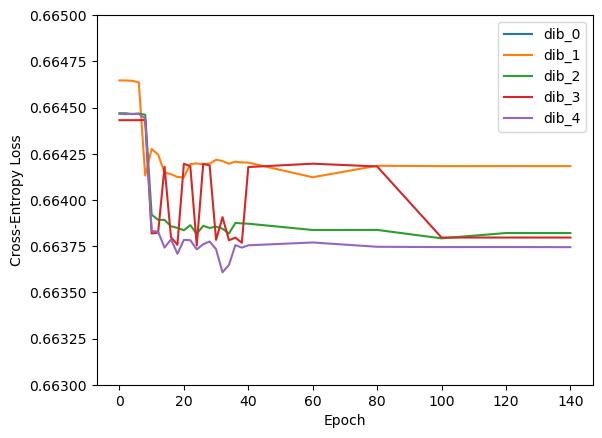

In [12]:
# remove NaN rows
no_nan = metrics.dropna()

# plot DIB
dib_cols = metrics.columns[metrics.columns.str.contains("dib_")]
no_nan.plot(x="epoch", y=dib_cols)
plt.ylim(0.663, 0.665)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.savefig("DIB.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

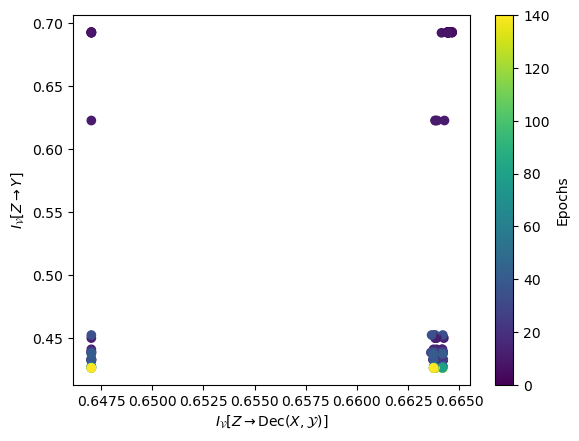

In [10]:
# IP analysis
for dib in dib_cols:
    plt.scatter(metrics[dib], metrics["train_loss"], cmap="viridis", c=metrics["epoch"])
    plt.plot(metrics[dib], metrics["train_loss"], color="gray", linewidth=0.5)
plt.xlabel(r"$I_{\mathcal{V}}[Z \to \operatorname{Dec}(X,\mathcal{Y})]$")
plt.ylabel(r"$I_{\mathcal{V}}[Z \to Y]$")
plt.colorbar(label="Epochs")
plt.show()